# Wine Quality Prediction

## Preliminaries

In this little example we will look at several ways to predict the quality of wine based on several measurable quanities. But remember, waine tasting is largely a matter of personal taste.

Frist, let's invoke some of the imports we will need.

In [1]:
import tensorflow as tf
import numpy as np
import os
import urllib
import random
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import tarfile
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

Next we need to make sure we have the data sets we needed downloaded. First let's get our data sets.

In [2]:
white_wine_file = "winequality-white.csv"
if not os.path.exists(white_wine_file):
    urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", white_wine_file)

red_wine_file = "winequality-red.csv"
if not os.path.exists(red_wine_file):
    urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", red_wine_file)


Now we need to load and explore the data set. Load them into memory using the numpy tooling. The columns have the following meaings:
'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality'. We will pretty much ignore these as we will be doing ML based only on non-expert traning straegies. We also separate out the labels from the features.

In [3]:
tags = np.array(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
ww = np.loadtxt(white_wine_file, skiprows=1, delimiter=';')
ww_labels = ww[:, 11] #quality label
ww_features = ww[:, range(11)]

rw = np.loadtxt(red_wine_file, skiprows=1, delimiter=';')
rw_labels = rw[:, 11]
rw_features = rw[:, range(11)]

w_hist, _ = np.histogram(ww_labels, [0,1,2,3,4,5,6,7,8,9,10,11])
r_hist, _ = np.histogram(rw_labels, [0,1,2,3,4,5,6,7,8,9,10,11])

wn = len(ww_features)
random.seed(28)

n_classes = 3
ww_ind = random.sample(range(wn), wn)

# map labels to 0's
label_map = [0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2]

#quality labels
ww_l_tr = np.array([label_map[int(ww_labels[ww_ind[i]])] for i in range(0, int(0.8*wn))])
ww_l_va = np.array([label_map[int(ww_labels[ww_ind[i]])] for i in range(int(0.8*wn)+1, int(0.9*wn))])
ww_l_te = np.array([label_map[int(ww_labels[ww_ind[i]])] for i in range(int(0.9*wn)+1, wn-1)])

#features (categories)
ww_f_tr = np.array([ww_features[ww_ind[i]] for i in range(0, int(0.8*wn))])
ww_f_va = np.array([ww_features[ww_ind[i]] for i in range(int(0.8*wn)+1, int(0.9*wn))])
ww_f_te = np.array([ww_features[ww_ind[i]] for i in range(int(0.9*wn)+1, wn-1)])

data_size = len(ww_f_tr)
#data_size = 1000

## Data Segmentation

Next we need to divide our data into training, validation, and test data sets. Typically we target 80, 10, 10. Just in case the existing data has some existing assumptions about the order, we will take random samples or each data set. Notice that we explicitly set the random number generator seed. This way we get the same partitioning everytime we rerun the program. 

Given the histograms above, we will combine the classes for the first 5 classes into on and the last 3 in to 1.

From this point on we will focus on the white wine only. The red wine is left to the reader.

In [5]:
wn = len(ww_features)
random.seed(28)

# Select 3 or 5 classes. Notice that when changing the number of classes, you need to delete the temporary
# directories and their contents, e.g. bottleneck, retain_logs, SavedFeatures, wines, wines_te, wines_tr, wines_va.
n_classes = 3
if n_classes == 5:
    label_map = [0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4]
if n_classes == 3:
    label_map = [0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2]

ww_ind = random.sample(range(wn), wn)
#wine samples 
ww_f_tr = np.array([ww_features[ww_ind[i]] for i in range(0, int(0.8*wn))])
ww_f_va = np.array([ww_features[ww_ind[i]] for i in range(int(0.8*wn)+1, int(0.9*wn))])
ww_f_te = np.array([ww_features[ww_ind[i]] for i in range(int(0.9*wn)+1, wn-1)])
#labels of quality
ww_l_tr = np.array([label_map[int(ww_labels[ww_ind[i]])] for i in range(0, int(0.8*wn))])
ww_l_va = np.array([label_map[int(ww_labels[ww_ind[i]])] for i in range(int(0.8*wn)+1, int(0.9*wn))])
ww_l_te = np.array([label_map[int(ww_labels[ww_ind[i]])] for i in range(int(0.9*wn)+1, wn-1)])

## Principle Component Analysis

The first thing we can do is try to reduce the dimensionality of the data, through a process called PCA. Our data is currently 11 dimensional, meaning if we tried to plot it on a graph it would require 11 axis to do so:

In [6]:
#Show some of our white wine data samples
df = pd.DataFrame( data = ww_f_tr[ range(data_size//300) , : ] , columns = tags) #DataFrame(data, indexs, columns)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,6.3,0.270,0.23,2.90,0.047,13.0,100.0,0.99360,3.28,0.43,9.8
1,8.3,0.220,0.38,14.80,0.054,32.0,126.0,1.00020,3.22,0.50,9.7
2,4.7,0.145,0.29,1.00,0.042,35.0,90.0,0.99080,3.76,0.49,11.3
3,6.5,0.230,0.38,1.30,0.032,29.0,112.0,0.99298,3.29,0.54,9.7
4,7.1,0.220,0.74,2.70,0.044,42.0,144.0,0.99100,3.31,0.41,12.2
5,6.8,0.240,0.35,6.40,0.048,44.0,172.0,0.99440,3.29,0.55,10.5
6,7.3,0.310,0.69,10.20,0.041,58.0,160.0,0.99770,3.06,0.45,8.6
7,8.3,0.180,0.30,1.10,0.033,20.0,57.0,0.99109,3.02,0.51,11.0
8,7.6,0.280,0.49,20.15,0.060,30.0,145.0,1.00196,3.01,0.44,8.5
9,7.6,0.445,0.44,14.50,0.045,68.0,212.0,0.99860,3.48,0.36,10.0


With PCA we can reduce the dimensionality of this data. This should have a number of advantages, mainly that reducing the dimensions reduces the 'noise' in the data, making training of our model easier, as well as making computations on the data faster. It is important to remember that if we build a classifier based on a data set with reduced dimensions, we must reduce the dimensions of our new unlabelled data before feeding it into the model.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [8]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

Now we put the data in a format suitable for PCA and perform PCA.

In [9]:
df = pd.DataFrame( data = ww_f_tr[ range(data_size) , : ] , columns = tags) 
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

In [10]:
#Change the number of principle components (n_components) 
#depending on how much of the variability in the data you wish to preserve
pca = PCA(n_components=3) 
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
#make the labels the same shape
ww_labels_reduced = ww_l_tr[range(data_size)]

So what is happening? The best way to visualize it is we are rotating our axis in the 11 dimensional space to find a new set of axis where most of the variability is captured along a few most important axis, called our 'principle components'. The result is a new set of axis where the 1st principle component captures the most variability and the 11th principle component captures the least. This way, by only keeping the first few principle components, we can hope to lose little information. 

<IPython.core.display.Javascript object>


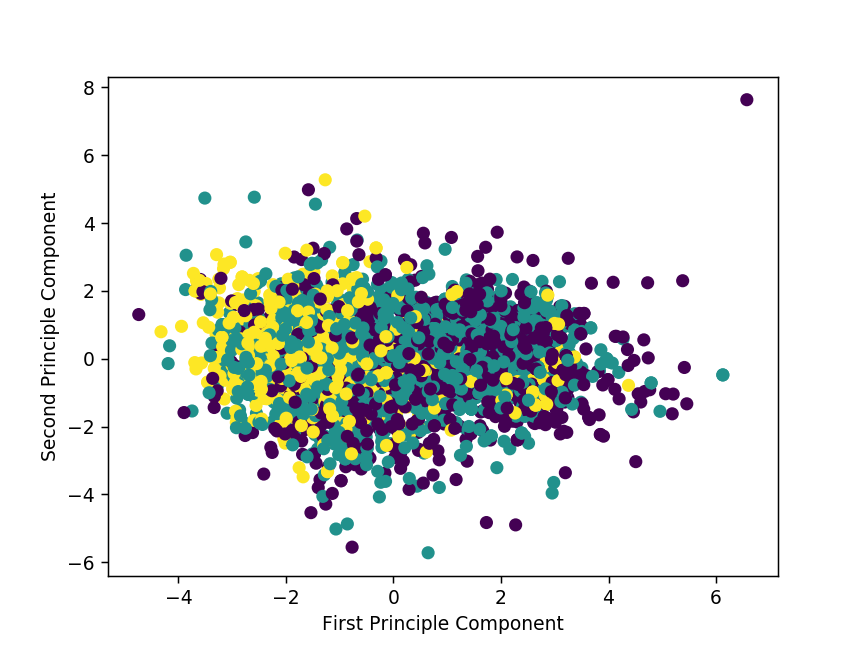

<IPython.core.display.Javascript object>


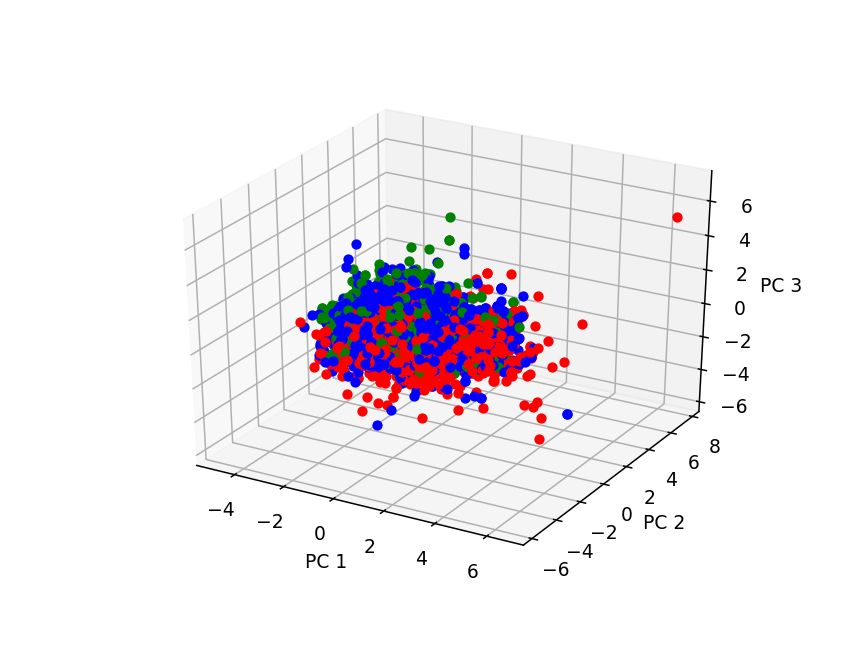

In [11]:
#2 PCs
fig = plt.figure()
ax = fig.add_subplot(111)
#we map the points to a colour depending on their label, stored in ww_labels_reduced
plt.scatter(x_pca[:,0],x_pca[:,1], c = ww_labels_reduced) 
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')

#3 PCs
x_pca = pca.transform(scaled_data)
ww_labels_reduced_2 = ww_labels_reduced.copy()
ww_labels_reduced_2.shape = (len(ww_labels_reduced),1)
x_pca_2 = np.append(x_pca,ww_labels_reduced_2,axis=1)
x_pca_2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for x, y, z, col in x_pca_2:
    #print(x,y,z,int(col))
    if(int(col)==0):
        color = 'Red'
    elif(int(col)==1):
        color = 'Blue'
    else:
        color = 'Green'
    
    ax.scatter(x, y, z, c = color )

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

After choosing to only keep the first two or three principle components, we plot our training data against their first and second principle component value, where the colour represents the three different classes the wines are in. Unfortunately, the results are non-conclusive. We would hope that the three different classes occupied their own region of the new space. If that was the case, we could construct a model (there are many algorithms that would work) that worked out the quality of the wine based on its position in the new space. 

In [11]:
print(pca.explained_variance_ratio_)

[0.29798021 0.14145052 0.11155431]


Here we can see how much variability each principle component preserves. The first principle component preserves 30% of the variability within the 11 dimensions. Together, the three components preserve 55% of the variability of the data. We can view the total spread of variability of all 11 principle components:

In [12]:
pca = PCA(n_components=11) 
pca.fit(scaled_data)
print(pca.explained_variance_ratio_)

[0.29798021 0.14145052 0.11155431 0.09256305 0.0873762  0.08415692
 0.06512259 0.0544429  0.0374376  0.02654502 0.00137067]


It is also important to remember that the principle component axis that have been made do not represent any of the old axis. When we rotate our axis to capture the variability in the data, the axis no longer keep their meaning. PCA is an unsupervised learning technique, so we do not know what we are looking for when we do it. In this case, we did it with the intention to find out some information about the nature of that data that may help us construct a classification model.

We will not use the results of the PCA going forward, but they have given us a clue that the data may be hard to construct a model on. This is beacuse the classes do not seem to hold much correlation with their position against their principle components.

## K Nearest Neighbour Classification

Let's start with a simple K Nearest Neighbours (KNN) style machine learning. This is a straingt forwards process requiring only a single traing step. Notice that we only list the results for the validation set. This is because we will be tuning the KNN parameters and don't want to over fit against the testing data set. To train the KNN classifier you can change the numbr of neighboours and the weighting strategy ('uniform' or 'distance').

In [14]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(ww_f_tr, ww_l_tr)

# Look at 10 of our validation set:
for i in range(10):
    pred = knn.predict([ww_f_va[i]])[0]
    probs = knn.predict_proba([ww_f_va[i]])
    if n_classes == 5:
        print ("Prediction = %1d Actual = %1d Probabilities = %5.3f %5.3f %5.3f %5.3f %5.3f" % 
            (pred, ww_l_va[i], probs[0][0], probs[0][1], probs[0][2], probs[0][3], probs[0][4]))
    if n_classes == 3:
        print ("Prediction = %1d Actual = %1d Probabilities = %5.3f %5.3f %5.3f" % 
            (pred, ww_l_va[i], probs[0][0], probs[0][1], probs[0][2]))
    
# Run the complete validation data set.
score = knn.score(ww_f_va, ww_l_va)
print("\n Overall score = %5.2f%%" % (100.0*score))


Prediction = 1 Actual = 0 Probabilities = 0.297 0.536 0.168
Prediction = 1 Actual = 1 Probabilities = 0.000 1.000 0.000
Prediction = 1 Actual = 1 Probabilities = 0.000 1.000 0.000
Prediction = 1 Actual = 1 Probabilities = 0.418 0.582 0.000
Prediction = 0 Actual = 0 Probabilities = 1.000 0.000 0.000
Prediction = 1 Actual = 1 Probabilities = 0.343 0.442 0.214
Prediction = 0 Actual = 0 Probabilities = 1.000 0.000 0.000
Prediction = 1 Actual = 1 Probabilities = 0.000 1.000 0.000
Prediction = 1 Actual = 1 Probabilities = 0.000 1.000 0.000
Prediction = 1 Actual = 1 Probabilities = 0.388 0.437 0.175

 Overall score = 67.28%


Lets have a closer look at how our system in performaing. We'll look at the false positives and false negatives for each class. False positive is where the class was incorrectly predicted; a false negative is where a wrong class was predicited. In our case we will have a false positive somewhere for every false negative, but any patterns in the distribution could be interesting.

In [15]:
fp = np.zeros(n_classes)
fn = np.zeros(n_classes)
n = len(ww_f_va)
tot = 0
print("N = ", n)
for i in range(n):
    pred = knn.predict([ww_f_va[i]])[0]
    if pred != ww_l_va[i]:
        tot = tot + 1
        fn[int(ww_l_va[i])] = fn[int(ww_l_va[i])] + 1
        fp[int(pred)] = fp[int(pred)] + 1

print("Total wrong = %3d. Eror rate = %8.4f%%" % (tot, 100.0*tot/n))
for i in range(n_classes):
    print("Class = %2d False positive = %3d (%5.1f%%) False negative = %3d (%5.1f%%)." % (i, fp[i], 100.0*fp[i]/n, fn[i
    ], 100.0*fn[i]/n))

N =  489
Total wrong = 160. Eror rate =  32.7198%
Class =  0 False positive =  54 ( 11.0%) False negative =  54 ( 11.0%).
Class =  1 False positive =  70 ( 14.3%) False negative =  67 ( 13.7%).
Class =  2 False positive =  36 (  7.4%) False negative =  39 (  8.0%).


The low false positives for the best and worst wines are encoraging. This means we are unlikely to be told a wine is good (or bad) incorrectly. However, we miss the oppertunity to sample about 4% of the best wines (false negatives), but these numbers too are relatively small.

Observing this ability to identify good, bad, and ok wines, the reader might wish to try further restricting the number of classes and see how well the classifier functions.

## Introduction to Imagification

The basic idea behine 'imigification' is that without needing to understand the detailed meaning of feature data we can still gain an insight into how well we might be able to classify this data. In the case of wine we were able to do pretty well with just using the KNN classifier, but in some cases there will be many more features or simply large volumes of data associated with each instance. In this case we want to develop a way to classify these without a detailed understanding of the specialist knowledge associated with the data.

We have also discovered that modern image perception networks are quite good with detail that sometimes humans miss. We would like to exploit this learning with a technique called transfer learning. So while the wine case may not seem to demand this approach, we'll have a go anyway to see how straight forward the process of imagification can be.

## Capturing the Data as Images

The first step in the process is to capture the data as images. Let's try a bar chart. [Note that we are normalizing all the features against the average across the whole data set so that all bars have about the same impact in the image.]Let's look at just one instance.

<IPython.core.display.Javascript object>


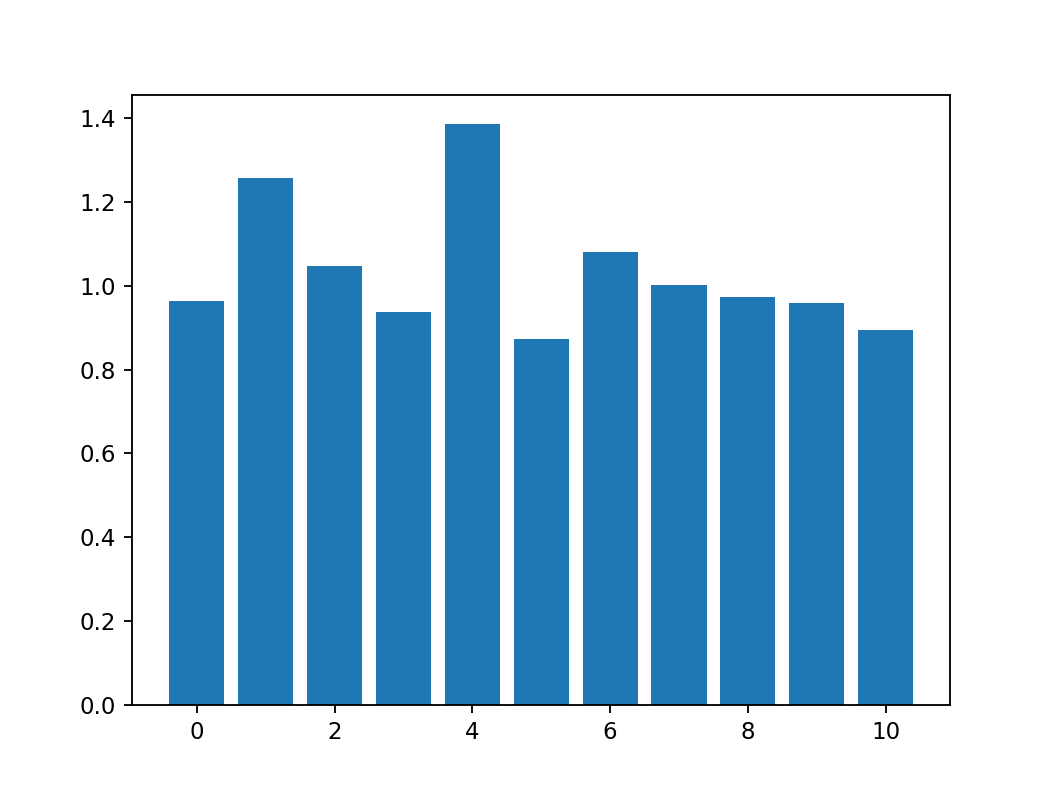

In [18]:
plt.close()
fig, bar = plt.subplots()
indx = range(11)
p = 220
features = [ww_f_tr[p][f]/np.average(ww_f_tr[:,f]) for f in range(11)]
bar.bar(indx, features)
plt.show()

We could also do them as Pie Charts, which deal with ratios rather than absolute amounts:

['#67CF31', '#690A8E', '#DD6B1D', '#1D0F4A', '#41787F', '#F45A9E', '#155E75', '#57DE3E', '#DBF447', '#7C2260', '#D17AE2']


<IPython.core.display.Javascript object>


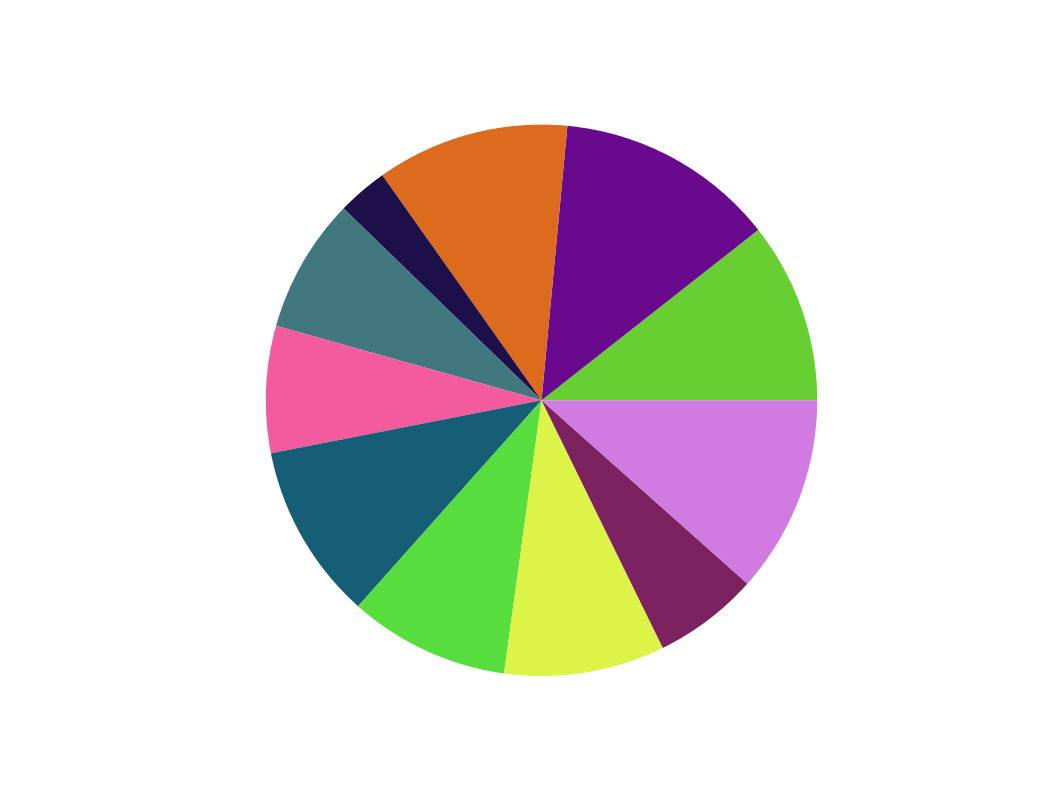

In [17]:
#pies will deal with ratios rather than absoloute amounts (all small values will look the same as all big values)
#try with sorted and without sorted, sorted would mean we're looking if the things are balanced in relation to eachother, 
#not caring which one is dominant
plt.close()
p=2500

from random import randint
random.seed(26)
colorsa = []
for i in range(11):
    colorsa.append('#%06X' % randint(0, 0xFFFFFF))
    
slices = [ww_f_tr[p][f]/np.average(ww_f_tr[:,f]) for f in range(11)]
fig1, ax1 = plt.subplots()
ax1.pie(slices,colors=colorsa)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Now we need to build the image data set to use in training the image recognizer. We will create three directories to stor the images, one each for training, validation, and testing. This step will take some time. Go have a coffee.<br> *Note: To use bar charts set bar = True, to use pie charts set bar = False*

In [23]:
#To use bar charts set bar = True, to use pie charts set bar = False
%matplotlib inline

bar = True

if(bar):
    if not os.path.exists("wines_tr"):
        os.makedirs("wines_tr")

        f_inds = range(11)
        for p in range (len(ww_f_tr)):
            features = ww_f_tr[p]
            for f in f_inds:
                features[f] = features[f]/np.average(ww_f_tr[:,f])

            plt.close()
            _, bar = plt.subplots()
            bar.bar(f_inds, features)
            plt.savefig("wines_tr/WW%04d.jpeg"%(p))

    if not os.path.exists("wines_va"):
        os.makedirs("wines_va")

        f_inds = range(11)
        for p in range (len(ww_f_va)):
            features = ww_f_va[p]
            for f in f_inds:
                features[f] = features[f]/np.average(ww_f_tr[:,f])

            plt.close()
            _, bar = plt.subplots()
            bar.bar(f_inds, features)
            plt.savefig("wines_va/WW%04d.jpeg"%(p))

    if not os.path.exists("wines_te"):
        os.makedirs("wines_te")

        f_inds = range(11)
        for p in range (len(ww_f_te)):
            features = ww_f_te[p]
            for f in f_inds:
                features[f] = features[f]/np.average(ww_f_tr[:,f])

            plt.close()
            _, bar = plt.subplots()
            bar.bar(f_inds, features)
            plt.savefig("wines_te/WW%04d.jpeg"%(p))
else:
    
    #create the pie chart colour mapping
    from random import randint
    random.seed(26)
    colorsa = []
    for i in range(11):
        colorsa.append('#%06X' % randint(0, 0xFFFFFF))
    colorsa[0] = '#FF0000'

    
    if not os.path.exists("wines_tr"):
        os.makedirs("wines_tr")

        f_inds = range(11)
        for p in range (len(ww_f_tr)):
            features = ww_f_tr[p]
            for f in f_inds:
                features[f] = features[f]/np.average(ww_f_tr[:,f])

            plt.close()
            _, ax1 = plt.subplots()
            ax1.pie(features, startangle=90, colors=colorsa)
            ax1.axis('equal')
            plt.savefig("wines_tr/WW%04d.jpeg"%(p))

    if not os.path.exists("wines_va"):
        os.makedirs("wines_va")

        f_inds = range(11)
        for p in range (len(ww_f_va)):
            features = ww_f_va[p]
            for f in f_inds:
                features[f] = features[f]/np.average(ww_f_tr[:,f])

            plt.close()   
            _, ax1 = plt.subplots()
            ax1.pie(features, startangle=90, colors=colorsa)
            ax1.axis('equal')
            plt.savefig("wines_va/WW%04d.jpeg"%(p))

    if not os.path.exists("wines_te"):
        os.makedirs("wines_te")

        f_inds = range(11)
        for p in range (len(ww_f_te)):
            features = ww_f_te[p]
            for f in f_inds:
                features[f] = features[f]/np.average(ww_f_tr[:,f])

            plt.close()
            _, ax1 = plt.subplots()
            ax1.pie(features, startangle=90, colors=colorsa)
            ax1.axis('equal')
            plt.savefig("wines_te/WW%04d.jpeg"%(p))

## Transfer Learning

As simple approach to imagification and transfer learing is to remove the final layer of an existing image recognizer and replace it with a KNN classifier using the final pooling layer are the source for our features. This easily demonstrates the ability to adapt CNNs for use in transfer learning. The success of ths approach depends on how well our images capture the essential infomration.

First make sure the Inception and TensorFlow environment is set up.

In [24]:
if not os.path.exists("model"):
    os.makedirs("model")
    
if not os.path.exists("model/inception-2015-12-05.tgz"):
    filepath, _ = urllib.request.urlretrieve(
            "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz", "model/inception-2015-12-05.tgz")
    tarfile.open(filepath, 'r:gz').extractall("model")
 

Now we need to run all our images through the Inception CNN and then set up a KNN to train against the Known labels.

In [25]:
# Set up Inception CNN.
tf.reset_default_graph()
f = tf.gfile.FastGFile("model/classify_image_graph_def.pb", 'rb')
graph_def = tf.GraphDef()
graph_def.ParseFromString(f.read())
tf.import_graph_def(graph_def, name='')
sess = tf.Session()

if os.path.exists ("SavedFeatures/tr_f.npy"):

    tr_features = np.load("SavedFeatures/tr_f.npy")
    tr_labels = np.load("SavedFeatures/tr_l.npy")
    va_features = np.load("SavedFeatures/va_f.npy")
    va_labels = np.load("SavedFeatures/va_l.npy")
    te_features = np.load("SavedFeatures/te_f.npy")
    te_labels = np.load("SavedFeatures/te_l.npy")

else:

    os.makedirs("SavedFeatures")
    
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')

    tr_features = np.empty((len(ww_f_tr), 2048), dtype='float32')
    tr_labels = np.empty(len(ww_l_tr), dtype='int')
    for i in range(len(ww_f_tr)):
        image_f = "wines_tr/WW%04d.jpeg" % (i)
        image = tf.gfile.FastGFile(image_f, 'rb').read()
        tr_features[i] = sess.run(pool3, {'DecodeJpeg/contents:0': image})[0][0][0]
        tr_labels[i] = ww_l_tr[i]
        if i % 100 == 0:
            print("Generating training feature set for image number = ", i)

    va_features = np.empty((len(ww_f_va), 2048), dtype='float32')
    va_labels = np.empty(len(ww_l_va), dtype='int')
    for i in range(len(ww_f_va)):
        image_f = "wines_va/WW%04d.jpeg" % (i)
        image = tf.gfile.FastGFile(image_f, 'rb').read()
        va_features[i] = sess.run(pool3, {'DecodeJpeg/contents:0': image})[0][0][0]
        va_labels[i] = ww_l_va[i]
        if i % 100 == 0:
            print("Generating validation feature set for image number = ", i)
            
    te_features = np.empty((len(ww_f_te), 2048), dtype='float32')
    te_labels = np.empty(len(ww_l_te), dtype='int')
    for i in range(len(ww_f_te)):
        image_f = "wines_te/WW%04d.jpeg" % (i)
        image = tf.gfile.FastGFile(image_f, 'rb').read()
        te_features[i] = sess.run(pool3, {'DecodeJpeg/contents:0': image})[0][0][0]
        te_labels[i] = ww_l_te[i]
        if i % 100 == 0:
            print("Generating ttest feature set for image number = ", i)

    np.save("SavedFeatures/tr_f.npy", tr_features)
    np.save("SavedFeatures/tr_l.npy", tr_labels)
    np.save("SavedFeatures/va_f.npy", va_features)
    np.save("SavedFeatures/va_l.npy", va_labels)
    np.save("SavedFeatures/te_f.npy", te_features)
    np.save("SavedFeatures/te_l.npy", te_labels)


Now train and validate our KNN based on the features extracted from the images.

In [26]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(tr_features, tr_labels)

# Look at 10 of our validation set:
for i in range(10):
    pred = knn.predict([va_features[i]])[0]
    probs = knn.predict_proba([va_features[i]])
    if n_classes == 5:
        print ("Prediction = %1d Actual = %1d Probabilities = %5.3f %5.3f %5.3f %5.3f %5.3f" % 
               (pred, va_labels[i], probs[0][0], probs[0][1], probs[0][2], probs[0][3], probs[0][4]))
    if n_classes == 3:
        print ("Prediction = %1d Actual = %1d Probabilities = %5.3f %5.3f %5.3f" % 
               (pred, va_labels[i], probs[0][0], probs[0][1], probs[0][2]))

# Run the complete validation data set.
score = knn.score(va_features, va_labels)
print("\n Overall score = %5.2f%%" % (100.0*score))


Prediction = 0 Actual = 0 Probabilities = 0.593 0.407 0.000
Prediction = 0 Actual = 1 Probabilities = 0.610 0.390 0.000
Prediction = 0 Actual = 1 Probabilities = 0.616 0.384 0.000
Prediction = 2 Actual = 1 Probabilities = 0.000 0.388 0.612
Prediction = 0 Actual = 0 Probabilities = 0.592 0.408 0.000
Prediction = 1 Actual = 1 Probabilities = 0.413 0.587 0.000
Prediction = 1 Actual = 0 Probabilities = 0.389 0.413 0.198
Prediction = 0 Actual = 1 Probabilities = 0.604 0.396 0.000
Prediction = 0 Actual = 1 Probabilities = 0.605 0.395 0.000
Prediction = 0 Actual = 1 Probabilities = 0.594 0.406 0.000

 Overall score = 40.90%


In [27]:
fp = np.zeros(11)
fn = np.zeros(11)
n = len(va_labels)
tot = 0
print("N = ", n)
for i in range(n):
    pred = knn.predict([va_features[i]])[0]
    if pred != va_labels[i]:
        tot = tot + 1
        fn[int(va_labels[i])] = fn[int(va_labels[i])] + 1
        fp[int(pred)] = fp[int(pred)] + 1

print("Total wrong = %3d. Eror rate = %8.4f%%" % (tot, 100.0*tot/n))
for i in range(n_classes):
    print("Class = %2d False positive = %3d (%5.1f%%) False negative = %3d (%5.1f%%)." % (i, fp[i], 100.0*fp[i]/n, fn[i
    ], 100.0*fn[i]/n))

        

N =  489
Total wrong = 289. Eror rate =  59.1002%
Class =  0 False positive = 117 ( 23.9%) False negative =  90 ( 18.4%).
Class =  1 False positive = 141 ( 28.8%) False negative = 109 ( 22.3%).
Class =  2 False positive =  31 (  6.3%) False negative =  90 ( 18.4%).


In [28]:
# Build the nested directory structure needed for the retraining approach.
if not os.path.exists("wines"):
    if n_classes == 5:
        os.makedirs("wines")
        os.makedirs("wines/undrinkable")
        os.makedirs("wines/poor")
        os.makedirs("wines/ok")
        os.makedirs("wines/good")
        os.makedirs("wines/excellent")
    if n_classes == 3:
        os.makedirs("wines")
        os.makedirs("wines/undrinkable")
        os.makedirs("wines/ok")
        os.makedirs("wines/excellent")
    
    f_inds = range(11)
    for p in range (len(ww_features)):
        features = ww_features[p]
        for f in f_inds:
            features[f] = features[f]/np.average(ww_features[:,f])
            
        plt.close()
        _, bar = plt.subplots()
        bar.bar(f_inds, features)
        lab = label_map[int(ww_labels[p])]
        if lab == 0:
            plt.savefig("wines/undrinkable/WW%04d.jpeg"%(p))
        if lab == 1:
            if n_classes == 5:
                plt.savefig("wines/poor/WW%04d.jpeg"%(p))
            if n_classes == 3:
                plt.savefig("wines/ok/WW%04d.jpeg"%(p))
        if lab == 2:
            if n_classes == 5:
                plt.savefig("wines/ok/WW%04d.jpeg"%(p))
            if n_classes == 3:
                plt.savefig("wines/excellent/WW%04d.jpeg"%(p))
        if lab == 3:
            plt.savefig("wines/good/WW%04d.jpeg"%(p))
        if lab == 4:
            plt.savefig("wines/excellent/WW%04d.jpeg"%(p))

The retrain.py application is part or the TensorFlow distribution and is discussed in detail in this tutorial: https://www.tensorflow.org/tutorials/image_retraining. This application has many options hat are worth exploring in the source code, but for now we will run it with just the defaults, which we have editied to meet our wines example.

In [29]:
%run "retrain.py"

Not extracting or downloading files, model already present in disk
Model path:  ./model\classify_image_graph_def.pb
INFO:tensorflow:Looking for images in 'excellent'
INFO:tensorflow:Looking for images in 'ok'
INFO:tensorflow:Looking for images in 'undrinkable'
INFO:tensorflow:500 bottleneck files created.
INFO:tensorflow:1000 bottleneck files created.
INFO:tensorflow:1500 bottleneck files created.
INFO:tensorflow:2000 bottleneck files created.
INFO:tensorflow:2500 bottleneck files created.
INFO:tensorflow:3000 bottleneck files created.
INFO:tensorflow:3500 bottleneck files created.
INFO:tensorflow:4000 bottleneck files created.
INFO:tensorflow:4500 bottleneck files created.
INFO:tensorflow:5000 bottleneck files created.
INFO:tensorflow:5500 bottleneck files created.
INFO:tensorflow:6000 bottleneck files created.
INFO:tensorflow:6500 bottleneck files created.
INFO:tensorflow:7000 bottleneck files created.
INFO:tensorflow:7500 bottleneck files created.
INFO:tensorflow:8000 bottleneck fil

The End